In [1]:
import numpy as np
import matplotlib.pyplot as plot

In this notebook, I present a practical example of what is actually happening when you train a Gaussian process model. I don't suggest you ever use this implementation to do actual machine learning. I have coded everything with readability in mind, at the cost of efficiency. There are also a bunch of cool linear algebra and numerical stability tricks that I have also skipped in the interest of simplicity.

The leading libraries for working with GPs (in Python) are;
* [GPy](https://sheffieldml.github.io/GPy/) - Probably the most popular
* [George](https://george.readthedocs.io/en/latest/) - Written by an astrophysicist I had beers with once, so maybe I'm biased, but this is the one I used to use as it gives the user a lot of flexibility and plays well with stochastic sampling methods
* [Scikit-Learn](https://scikit-learn.org/stable/modules/gaussian_process.html) - Used to be considered a poor implementation, not sure if that is still true

First, some notation. We have;

* $x_t$ - the inputs for our training data
* $y_t$ - the outputs for our training data
* $x_p$ - the inputs for which we want to predict the output
* $y_p$ - the (unknown) outputs that we want to predict

We generate some training data;

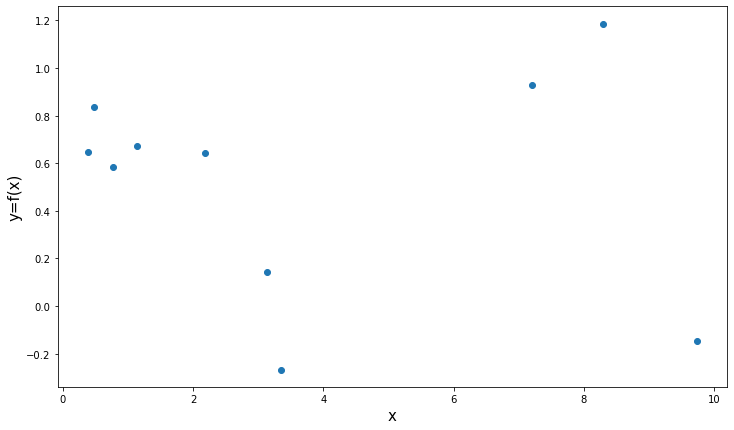

In [2]:
np.random.seed(8235)

n_data = 10
measurement_uncertainty = 0.2

x_t = 10 * np.sort(np.random.rand(n_data))
y_t = np.sin(x_t)  + measurement_uncertainty * np.random.randn(len(x_t))

x_p = np.linspace(min(x_t)-1, max(x_t)+1, 200)

fig, axs = plot.subplots()
fig.set_size_inches(12,7)
axs.set_xlabel('x', size=15)
axs.set_ylabel('y=f(x)', size=15)
axs.scatter(x_t, y_t);

Our model is that our outputs are jointly Gaussian distributed, i.e.,

$$  P(y_p|y_t) \propto P(y_p,y_t) \propto \exp\left[-\frac{1}{2} \left(\begin{array}{c} y_t \ y_p \end{array}\right)^T\Sigma^{-1}\left(\begin{array}{c} y_t \ y_p \end{array}\right)\right]  $$

Where ($y_t, y_p$) is the concatenated vector of our known and unknown outputs and $\Sigma$ is the covariance matrix between all of the outputs.

The problem is, we don't know $y_p$, so we can't compute this directly. We therefore make the _assumption_ that we can approximate the covariance between two outputs ($y_t, y_p$) as a function of the inputs ($x_t, x_p$).

The standard choice for this function is the "squared exponential" kernel, but remember that this is just a choice!

$$ \Sigma_{ij} = \langle y_i, y_j\rangle \approx \kappa(x_i, x_j) = \exp\left(-\frac{(x_i - x_j)^2 }{2l^2} \right) + \alpha\delta_{ij} $$

Where here $l$ is our free parameter, $\alpha$ is our (homoskedastic) measurement uncertainty and $\delta_{ij}$ is the Kroenecker delta function. 

In [3]:
def kernel(xi, xj, l):
    """
    Remember, any positive definite, symmetric function of the inputs will do here!
    """
    
    squared_residual = np.square(xi-xj)
    covariance = np.exp(-1*squared_residual/(2*l*l))
    return covariance

def kernel_matrix(xs, l):
    """
    Since the matrices are symmetric, we can compute them more efficiently
    """
    
    n = len(xs)
    
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            M[i,j] = kernel(xs[i], xs[j], l)
    M = M + M.T
    for i in range(n):
        M[i,i] = kernel(xs[i], xs[i], l) + measurement_uncertainty**2
        
    return M

The first step is to figure out what the free parameters are (train the Gaussian process model).

The $\Sigma$ in the Likelihood function above contains covariances between the training outputs ($y_t$) and the predicted outputs ($y_p$). It is convenient to consider the different blocks of this matrix;

$$ \Sigma = \left(\begin{array}{cc} T & C^T \\ C & P \end{array}\right) $$

* $T$ - the covariance matrix for the training outputs, made by taking pairwise covariances $\langle y_t,y_t \rangle$
* $P$ - the covariance matrix for the outputs we want to predict, made by taking pairwise covariances $\langle y_p,y_p \rangle$
* $C$ - the covariance matrix between the known, training outputs and the unknown outputs to predict $\langle y_p,y_t \rangle$

Since we're still assuming that our outputs are jointly Gaussian distributed, we use a Gaussian likelihood for this also, in order to find the most likely values for our free parameter $l$.

$$ P(\alpha, l | x_t, f_t) = P(T | x_t, y_t) \propto  \frac{1}{2|T|} \exp\left(-\frac{1}{2}y_t^T T^{-1} y_t \right)  $$

Where the elements of $T$ can be computed using the Kernel function, which is a function of $l$.

In [4]:
# logs are more stable, and are monotonic so work for maximisation
# since l must be positive, we pass its logarithm for optimisation later
def neg_log_likelihood(log_l):
    
    l = np.exp(log_l)
                
    T = kernel_matrix(x_t, l)
        
    # multivariate Gaussian log likelihood
    ll = -0.5*np.log(np.linalg.det(T)) - (0.5*np.dot(y_t,np.linalg.solve(T, y_t))) - np.log(2.*np.pi)
    
    print(f"Log Likelihood: {ll}")
                            
    return -ll

For simplicity, I will optimise the likelihood using a scipy routine, but it's quite common to use a full Bayesian treatment here, since Gaussian likelihoods are very fast to compute.

In [5]:
from scipy.optimize import minimize

In [6]:
print('Optimising l:')
print()
l0 = np.log(0.5)
result = minimize(neg_log_likelihood, l0)
l_max = result.x[0]
print()
print(f"Best l = {np.exp(l_max)}")

Optimising l:

Log Likelihood: -1.2038508653292523
Log Likelihood: -1.2038508247602695
Log Likelihood: 1.4986278795149
Log Likelihood: 1.498627896855321
Log Likelihood: -1.0046019674290614
Log Likelihood: -1.0046021266283782
Log Likelihood: 1.5969944183769633
Log Likelihood: 1.5969944224813575
Log Likelihood: 1.6017623612261378
Log Likelihood: 1.6017623604491251
Log Likelihood: 1.6019256745168962
Log Likelihood: 1.6019256745553445
Log Likelihood: 1.6019260806170736
Log Likelihood: 1.6019260806174316
Log Likelihood: 1.6019260806518476
Log Likelihood: 1.6019260806518472

Best l = 1.6259474735691932


Now that we have our optimised value for $l$, we can compute all of the other values of $\Sigma$. From this, we can plug straight in to the Gaussian process update equations (the derivation of these is long, but you can see the full derivation on some loser's blog [here](http://www.concernsofadataguy.com/blog/4)), which define a multivariate Gaussian distribution from which our function is drawn

$$ P(y_p|y_t) \sim \mathcal{N}(CT^{-1}y_t, P-CT^{-1}C^T) $$

So that our predictions are given by the mean vector

$$ \mu \approx CT^{-1}y_t $$

with uncertainty summarised by the covariance matrix

$$ \Sigma \approx P-CT^{-1}C^T$$


In [7]:
# compute the parts of the matrix

C = np.zeros((len(x_p), len(x_t)))
for i in range(len(x_p)):
    for j in range(len(x_t)):
        C[i, j] = kernel(x_p[i], x_t[j], l_max)
        
P = kernel_matrix(x_p, l_max)
T = kernel_matrix(x_t, l_max)

In [8]:
# get our distribution over functions

mu_p = np.dot(C, np.linalg.solve(T, y_t))
cov_p = P - np.dot(C, np.dot(np.linalg.inv(T), C.T))
sig_p = np.sqrt(np.diag(cov_p))

We now have the mean and covariance of our function, so we can show our best guess, with uncertainty, of what our approximation might look like

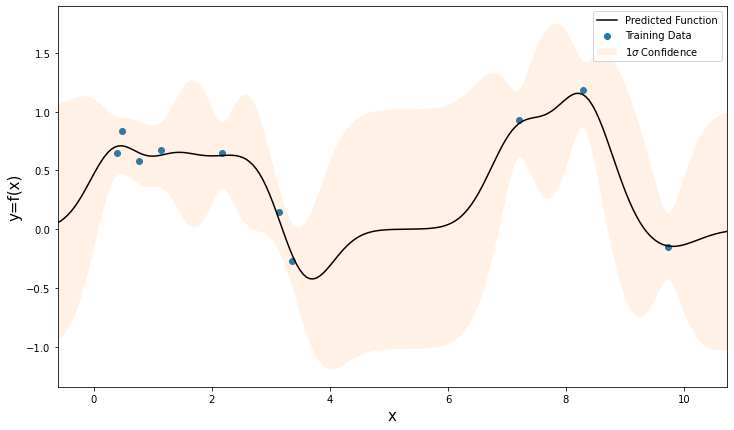

In [9]:
fig, axs = plot.subplots()


axs.scatter(x_t, y_t, label='Training Data')
axs.fill_between(x_p, mu_p - sig_p, mu_p + sig_p, alpha=0.1, label=r'$1\sigma$ Confidence')
axs.plot(x_p, mu_p, label='Predicted Function', color='k')
axs.set_xlim(min(x_p),max(x_p))
axs.legend()

axs.set_xlabel('x', size=15)
axs.set_ylabel('y=f(x)', size=15)

fig.set_size_inches(12,7)